# UCC benchmarks
In this notebook, we benchmark the performance of Unitary Fund's UCC compiler against qiskit, PyTKET and Cirq across a range of benchmarks (100 qubits each): 

- Quantum Approximate Optimization Algorithm (QAOA)
- Quantum Fourier transform (QFT)
- Quantum volume  (QV) calculation
- Square Heisenberg model Trotterized Hamiltonian simulation
- Quantum computational neural network (QCNN)
- PREPARE & SELECT on a GHZ state
- *Parameterized circuit Variational Quantum Eigensolver (VQE)* <-- to be implemented>

#### Circuit definitions
For the **QAOA, QFT, Square Heisenberg,** and **QV** circuits, we copy the corresponding [OpenQASM 2 code](https://github.com/qiskit/benchpress/tree/main/benchpress/qasm) from qiskit's benchpress library. For the QCNN and Prepare & Select circuits, we generate QASM 2 code using our own implementations in qiskit and cirq with target basis set:

`['rz', 'rx', 'ry', 'h', 'cx']`.

In [1]:
folder = "./circuits/qasm2/"

qasm_files = [folder + file for file in [
    "benchpress/qaoa_barabasi_albert_N100_3reps.qasm", # Is this one already optimal?
    "benchpress/qft_N100.qasm",
    "benchpress/qv_N100_12345.qasm",
    "benchpress/square_heisenberg_N100.qasm",
    "ucc/prep_select_N25_ghz.qasm",
    "ucc/qcnn_N100_7layers.qasm"
    ]]


#### Transpilation
For all benchmarks, we then use qbraid's [transpile](https://docs.qbraid.com/sdk/user-guide/transpiler) function to translate into the native format each SDK's compiler. 

**Note**: `qbraid.transpile` does NOT perform any circuit optimization; it only translates between circuit representations. 

#### Compilation
We then run a compiler pass on the circuit for each SDK, including decomposition into a target basis set to maintain parity in counting 2-qubit gates (shown below). Since there is not a default set of compiler passes for `Cirq` or `PyTKET`, we chose a subset of those available.  We invite anyone more familiar with these compiler libraries to suggest more optimal passes. 

However, it is worth pointing out that a major goal of UCC is to simplify the process of compilation for quantum developers and provide a "good default" set of passes that is on par with other compilers, without the user needing to specify any additional parameters.

In [2]:
from qiskit import transpile as qiskit_transpile

def qiskit_compile(qiskit_circuit):
    """Compile given qiskit.QuantumCircuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    raw_gates = qiskit_circuit.count_ops()
    num_raw_gates = raw_gates.get("cz", 0) + raw_gates.get("cx", 0)

    # TODO: check if this basis specification is needed (i.e. if it only gets the target basis set as input, will it compile to unitaries anyway?)
    compiled_circuit = qiskit_transpile(qiskit_circuit, optimization_level=3, basis_gates=['rz', 'rx', 'ry', 'h', 'cx'])
    compiled_gates = compiled_circuit.count_ops()
    num_compiled_gates = compiled_gates.get("cz", 0) + compiled_gates.get("cx", 0)
    
    return compiled_circuit, num_raw_gates, num_compiled_gates

In [3]:
from cirq.transformers import optimize_for_target_gateset, CZTargetGateset


def cirq_compile(cirq_circuit):
    """Compile given cirq.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    num_raw_gates = sum(
        1 for op in cirq_circuit.all_operations() if len(op.qubits) == 2)

    # Compiler passes
    compiled_circuit = optimize_for_target_gateset(
    cirq_circuit, 
    gateset=CZTargetGateset() # Other gatesets are not implemented in cirq
    )

    # Total 2-qubit gates in compiled Cirq circuit
    num_compiled_gates = sum(
        1 for op in compiled_circuit.all_operations() if len(op.qubits) == 2)

    return compiled_circuit, num_raw_gates, num_compiled_gates


In [19]:
# Compile using TKET
from pytket.circuit import OpType
from pytket.predicates import CompilationUnit
from pytket.passes import DecomposeMultiQubitsCX, DecomposeBoxes, SequencePass, auto_rebase_pass, SimplifyInitial, FullPeepholeOptimise
from pytket.transform import Transform

def pytket_compile(pytket_circuit):
    """Compile given pytket.Circuit object and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    compilation_unit = CompilationUnit(pytket_circuit)
    num_raw_gates = pytket_circuit.n_2qb_gates()

    seqpass = SequencePass(
            [
                SimplifyInitial(),
                DecomposeBoxes(),
                DecomposeMultiQubitsCX(),
                auto_rebase_pass({OpType.Rx, OpType.Ry, OpType.Rz, OpType.CX, OpType.H}),
                # FullPeepholeOptimise(), # Extremely slow
            ]
        )
    
    seqpass.apply(compilation_unit) # In-place

    compiled_circuit = compilation_unit.circuit
    num_compiled_gates = compiled_circuit.n_2qb_gates()

    return compiled_circuit, num_raw_gates, num_compiled_gates


In [20]:
from ucc import compile 

def ucc_compile(circuit):
    """Compile given qiskit.QuantumCircuit and return the compiled circuit and total number of raw and compiled 2 qubit gates"""
    raw_gates = circuit.count_ops()
    num_raw_gates = raw_gates.get("cz", 0) + raw_gates.get("cx", 0)
    # TODO: add a check that there are no other 2 qubit gates hiding in the dict
    
    compiled_circuit, compiled_gates = compile(circuit, get_gate_counts=True)
    num_compiled_gates = compiled_gates.get("cz", 0) + compiled_gates.get("cx", 0)
    # TODO: add a check that there are no other 2 qubit gates hiding in the dict

    return compiled_circuit, num_raw_gates, num_compiled_gates

In [21]:
from time import time

def log_performance(compiler_function, circuit):
    t1 = time()
    compiled_circuit, num_raw_gates, num_compiled_gates = compiler_function(circuit)
    t2 = time()
    
    log = {"compile_time": t2 - t1}
    log["raw_2q_gates"] = num_raw_gates
    log["compiled_2q_gates"] = num_compiled_gates
    # Should also log the compiler software version
    
    return compiled_circuit, log

In [22]:
results_log = []

In [23]:

print(qasm_files[3:])

['./circuits/qasm2/benchpress/square_heisenberg_N100.qasm', './circuits/qasm2/ucc/prep_select_N25_ghz.qasm', './circuits/qasm2/ucc/qcnn_N100_7layers.qasm']


In [29]:
from qbraid.transpiler import transpile as translate

compiler_specs = [
    ('ucc', ucc_compile), 
    ('qiskit', qiskit_compile),
    ('pytket', pytket_compile),
    ('cirq', cirq_compile)
]
for filename in qasm_files[:3]:
    # Open the QASM file and read its content into a string
    with open(filename, "r") as file:
        qasm_string = file.read()
        for alias, compile_func in compiler_specs:
            if alias == 'ucc':
                # Qiskit used for UCC to get raw gate counts
                native_circuit = translate(qasm_string, 'qiskit')
            else:
                native_circuit = translate(qasm_string, alias)
            compiled, log_entry = log_performance(compile_func, native_circuit)
            log_entry['compiler'] = alias
            log_entry['circuit_name'] = filename.split('/')[-1]
            print(log_entry)
            log_entry['raw_circuit'] = native_circuit
            log_entry['compiled_circuit'] = compiled
            results_log.append(log_entry)
            

{'compile_time': 0.14721989631652832, 'raw_2q_gates': 1176, 'compiled_2q_gates': 1176, 'compiler': 'ucc', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 0.4651153087615967, 'raw_2q_gates': 1176, 'compiled_2q_gates': 1176, 'compiler': 'qiskit', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 0.020759105682373047, 'raw_2q_gates': 1176, 'compiled_2q_gates': 1176, 'compiler': 'pytket', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 5.443670034408569, 'raw_2q_gates': 1176, 'compiled_2q_gates': 1176, 'compiler': 'cirq', 'circuit_name': 'qaoa_barabasi_albert_N100_3reps.qasm'}
{'compile_time': 1.138343095779419, 'raw_2q_gates': 10050, 'compiled_2q_gates': 4648, 'compiler': 'ucc', 'circuit_name': 'qft_N100.qasm'}
{'compile_time': 23.397634267807007, 'raw_2q_gates': 10050, 'compiled_2q_gates': 3244, 'compiler': 'qiskit', 'circuit_name': 'qft_N100.qasm'}
{'compile_time': 0.2191298007965088, 'raw_2q_gates': 10050, 'compil

In [52]:
import pandas as pd

# Convert results_log to a DataFrame
df = pd.DataFrame(results_log)


df['reduction_factor'] =  df['raw_2q_gates'] / df['compiled_2q_gates'] 
df['gate_reduction_per_s'] = df['reduction_factor'] / df['compile_time']

df_og = pd.DataFrame(results_log)

df = df.groupby(["circuit_name", "compiler"]).agg(
    compile_time=("compile_time", "mean"),
    raw_2q_gates=("raw_2q_gates", "mean"),
    compiled_2q_gates=("compiled_2q_gates", "mean"),
    gate_reduction_per_s=("gate_reduction_per_s", "mean"),
    reduction_factor=("reduction_factor", "mean"),
).reset_index()

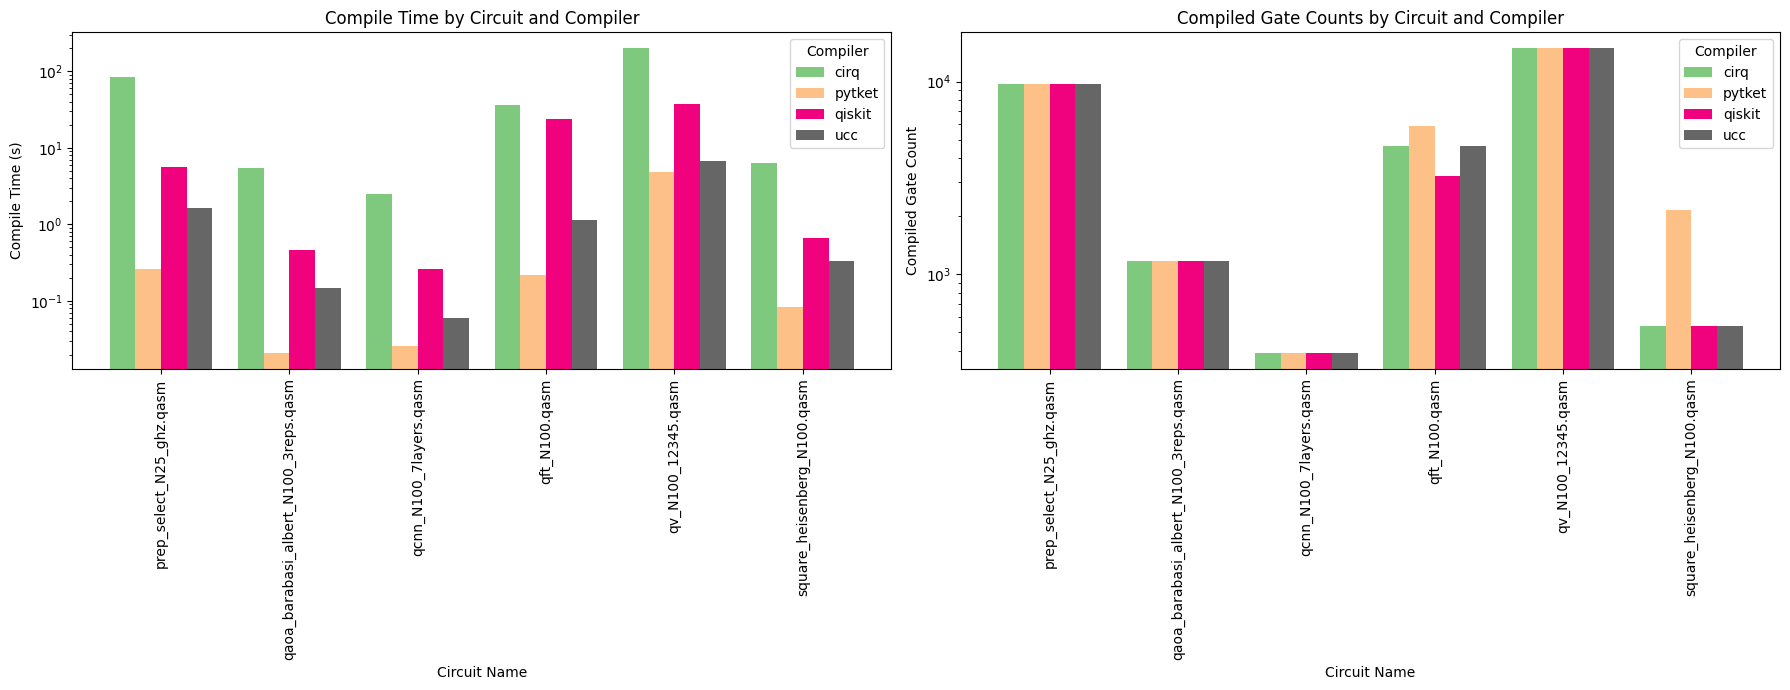

In [53]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Define a colormap and get unique compilers
unique_compilers = df["compiler"].unique()
colormap = plt.get_cmap("Accent", len(unique_compilers))
color_map = {compiler: colormap(i) for i, compiler in enumerate(unique_compilers)}

# Define bar width and x-offset for side-by-side plotting
bar_width = 0.2  # Adjust width to make bars skinnier
x = pd.Series(range(len(df["circuit_name"].unique())))  # X positions for each circuit

# Plot 1: Compile Time by Circuit and Compiler
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "compile_time"])
    ax[0].bar(x + i * bar_width, grp["compile_time"], width=bar_width, label=key, color=color_map[key])

# Format the first plot
ax[0].set_title("Compile Time by Circuit and Compiler")
ax[0].set_xlabel("Circuit Name")
ax[0].set_ylabel("Compile Time (s)")
ax[0].set_yscale("log")  # Set log scale
ax[0].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[0].set_xticklabels(df["circuit_name"].unique())
ax[0].legend(title="Compiler")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Plot 2: Compiled Gate Counts by Circuit and Compiler 
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "compiled_2q_gates"])
    ax[1].bar(x + i * bar_width, grp["compiled_2q_gates"], width=bar_width, label=key, color=color_map[key])

# Format the second plot
ax[1].set_title("Compiled Gate Counts by Circuit and Compiler")
ax[1].set_xlabel("Circuit Name")
ax[1].set_ylabel("Compiled Gate Count")
ax[1].set_yscale("log")  # Set log scale

ax[1].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[1].set_xticklabels(df["circuit_name"].unique())
ax[1].legend(title="Compiler")
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels


# Show the plot
plt.tight_layout()

plt.show()


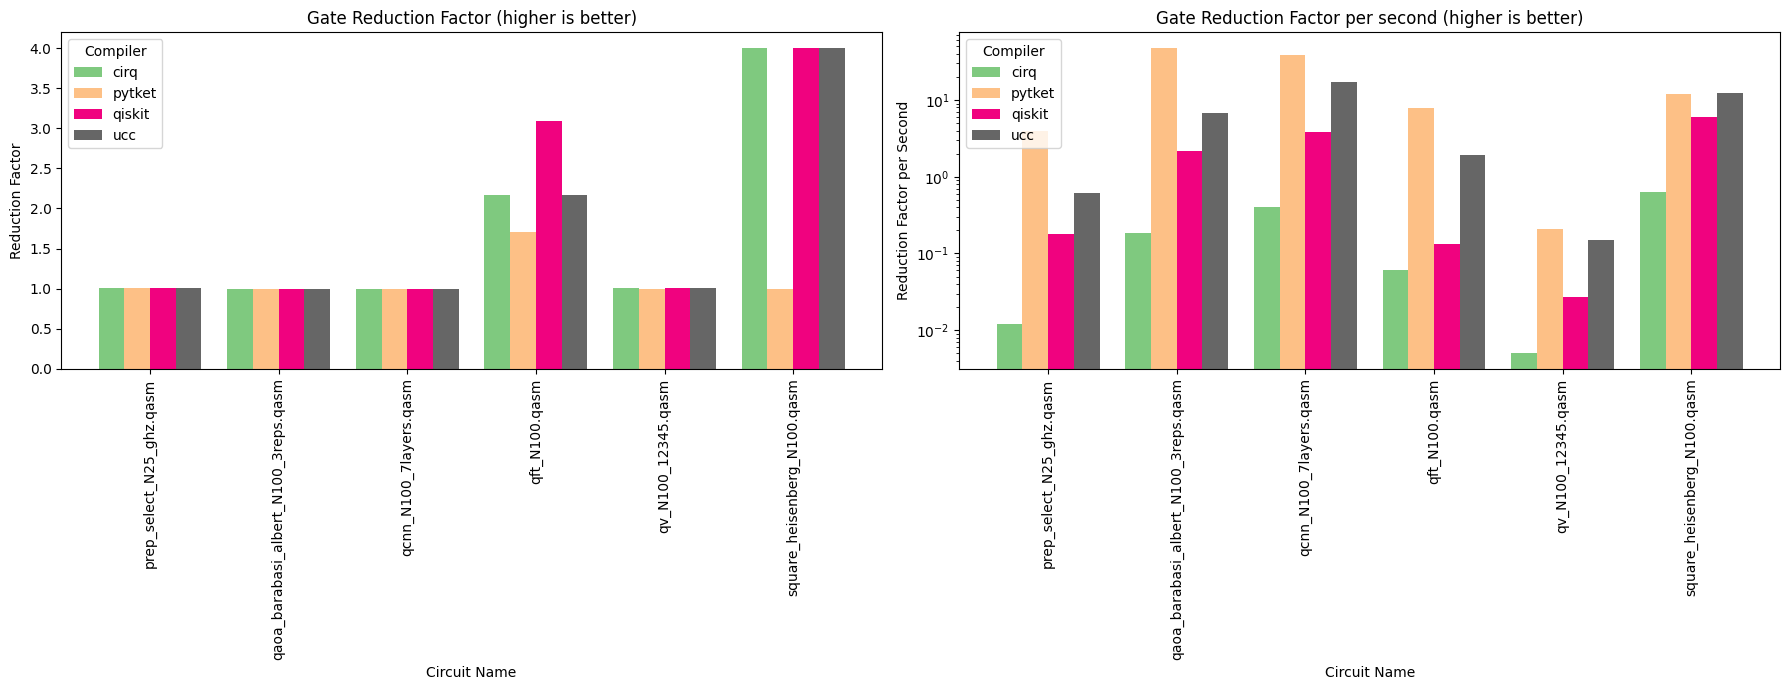

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))


# Plot 1: Reduction Factor by Circuit and Compiler in ax[0]
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "reduction_factor"])
    ax[0].bar(x + i * bar_width, grp["reduction_factor"], width=bar_width, label=key, color=color_map[key])

# Format the first plot (ax[0])
ax[0].set_title("Gate Reduction Factor (higher is better)")
ax[0].set_xlabel("Circuit Name")
ax[0].set_ylabel("Reduction Factor")
# Optionally, set log scale if needed:
# ax[0].set_yscale("log")

# Set x-tick positions and labels for ax[0]
ax[0].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[0].set_xticklabels(df["circuit_name"].unique())
ax[0].legend(title="Compiler")
ax[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Plot 2: Reduction Factor per Second by Circuit and Compiler in ax[1]
for i, key in enumerate(unique_compilers):
    # Offset x-positions for each compiler to place bars side-by-side
    grp = df[df["compiler"] == key].sort_values(by=["circuit_name", "gate_reduction_per_s"])
    ax[1].bar(x + i * bar_width, grp["gate_reduction_per_s"], width=bar_width, label=key, color=color_map[key])

# Format the third plot (ax[1])
ax[1].set_title("Gate Reduction Factor per second (higher is better)")
ax[1].set_xlabel("Circuit Name")
ax[1].set_ylabel("Reduction Factor per Second")
# Optionally, set log scale if needed:
ax[1].set_yscale("log")


# Set x-tick positions and labels for ax[1]
ax[1].set_xticks(x + bar_width * (len(unique_compilers) - 1) / 2)  # Center x-tick labels
ax[1].set_xticklabels(df["circuit_name"].unique())
ax[1].legend(title="Compiler")
ax[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

# Show the plot
plt.tight_layout()

plt.show()


***A note on terminology***

There is some disagreement in the quantum computing community on the proper usage of the terms "transpilation" and "compilation." For instance, Qiskit refers to optimization of the Directed Acyclic Graph (DAG) of a circuit as "transpilation," whereas in qBraid, the 1:1 translation of one circuit representation into another (e.g. a Cirq circuit to a Qiskit circuit; OpenQASM 2 into PyTKET) without optimization is called "transpilation." Cirq on the other hand appears to use the terminology of "transformers" to refer to what Qiskit calls transpiler passes, which PyTKET appears to call CompilationUnits. 

This cornucopia of intersecting definitions does mean that this notebook necessarily mixes terminology. We feel relatively confident we've interpreted these objects and operations accurately across the SDKs we test, but if you find a mistake, please create an issue and let us know!

Within the UCC library, we refer to **transpilation** in the same sense as Qiskit: optimizing the DAG of a circuit in a fixed representation. We then use **compilation** to refer to the whole process, including translation from one circuit representation to another (e.g. OpenQASM 2 to Qiskit), plus DAG optimization (e.g. reducing the number of gates), but we also leave it open-ended to include additional stages in the future, like dynamic compilation based on mid-circuit measurements, quantum error mitigation, and even quantum error correction. [probably needs a diagram]